In [1]:
using DataFrames
using Gadfly
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [3]:
function dist_mode(freq::Float64)
    # Declaro cte de boltzmann, avogadro, y temperatura.
    Kb = 1.38064852e-23
    A = 6.0221409e+23
    T = 298
    AKbT = A * Kb * T
    
    return d^2 * 0.5 * KBT * evals.^2 / cte # KJ/mol
end

dist_mode (generic function with 1 method)

In [4]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 300
    const RT_cal = 0.593 # Kcal/mol
    const RT = k * avgdro * T * .001 # KJ/mol
    const RT_ = k * avgdro * T # J/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # KJ/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [5]:
pdb = "1ael"
# Leo modos
modes_1ael, evals_1ael = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AA
aa3 = convert(Int64, length(evals_1ael))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_1ael = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_1ael = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_1ael = eval(:(ndd_out_1ael .- vol_avg_1ael))
vgv_1ael = vgv_1ael ./ norm(vgv_1ael);

### Obtiene los aa's del hueco

In [9]:
# VGV cartesiano
xyz_vgv_1ael = tognm(modes_1ael * vgv_1ael)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_1ael = get_pnum(xyz_vgv_1ael)

# Índices de pnumber aminoácidos
idx_cut_1ael = sort(sortperm(abs.(xyz_vgv_1ael), rev = true)[1:cut_1ael])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_1ael_3 = Array{Int64}(length(idx_cut_1ael) * 3)
for i = 1:length(idx_cut_1ael)
    idx_cut_1ael_3[3*i-2] = idx_cut_1ael[i] * 3 - 2
    idx_cut_1ael_3[3*i-1] = idx_cut_1ael[i] * 3 - 1
    idx_cut_1ael_3[3*i] = idx_cut_1ael[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [10]:
# Pnumber de VGV
vgv_pnu_1ael = get_pnum(vgv_1ael)

# Pnumber indices
idx_vgv_pnu_1ael = sortperm(abs.(vgv_1ael), rev=true)[1:vgv_pnu_1ael]

# Pnumber modes
modes_pnu_1ael = modes_1ael[:, idx_vgv_pnu_1ael]

# Pnumber eigenvalues
evals_pnu_1ael = evals_1ael[idx_vgv_pnu_1ael];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_1ael = modes_1ael[idx_cut_1ael_3, :]
modes_cut_1ael = mapslices(x -> x ./ norm(x), modes_cut_1ael, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_1ael = modes_pnu_1ael[idx_cut_1ael_3, :]
modes_pnu_cut_1ael = mapslices(x -> x ./ norm(x), modes_pnu_cut_1ael, 1);

### κ

In [11]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)))
κ_modes_1ael = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_1ael, 1), 1)))
κ_modes_pnu_1ael  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)
κ_modes_cut_1ael  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_1ael, 1), 1)
κ_modes_pnu_cut_1ael = reshape(tmp, length(tmp))

2-element Array{Float64,1}:
 0.828293
 0.53263 

### Pnumber

In [12]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_1ael, 1), 1)
col_modes_1ael = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_1ael, 1), 1)
col_modes_pnu_1ael = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_1ael, 1), 1)
col_modes_cut_1ael = reshape(tmp, length(tmp))  ./ cut_1ael

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_1ael, 1), 1)
col_modes_pnu_cut_1ael = reshape(tmp, length(tmp))  ./ cut_1ael;

# Frecuencia

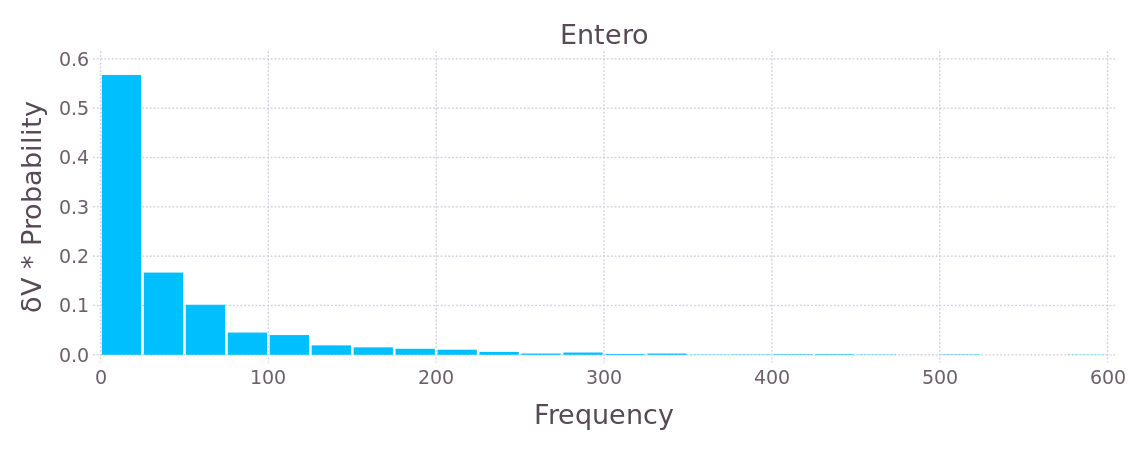

In [13]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_1ael)
bins_evals = collect(0:25:top_evals)

# Histograma ponderado
Whis_evals_1ael, Wbins_evals_1ael = WeightedHist(evals_1ael, bins_evals, abs.(vgv_1ael), true);
df_Whis_evals_1ael = DataFrame(Probability = Whis_evals_1ael, Frequency = Wbins_evals_1ael);


pdf_Whis_evals_1ael = plot(df_Whis_evals_1ael, x="Frequency", y="Probability", Geom.bar,
    Guide.title("Entero"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad

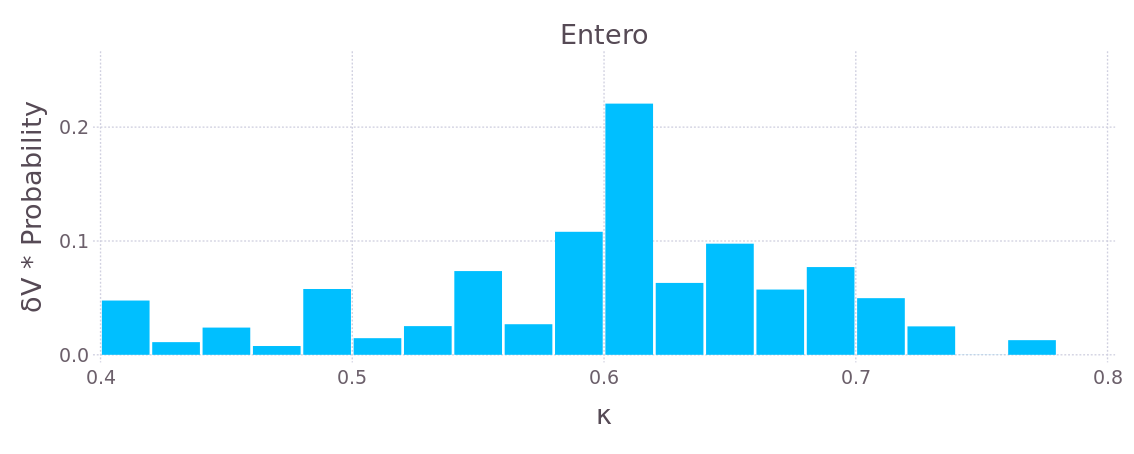

In [14]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_1ael)
bins_κ = collect(0.4:.02:.8)

# Histograma ponderado
Whis_κ_1ael, Wbins_κ_1ael = WeightedHist(κ_modes_1ael, bins_κ, abs.(vgv_1ael), true);
df_Whis_κ_1ael = DataFrame(Probability = Whis_κ_1ael, κ = Wbins_κ_1ael);

pdf_Whis_κ_1ael = plot(df_Whis_κ_1ael, x="κ", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

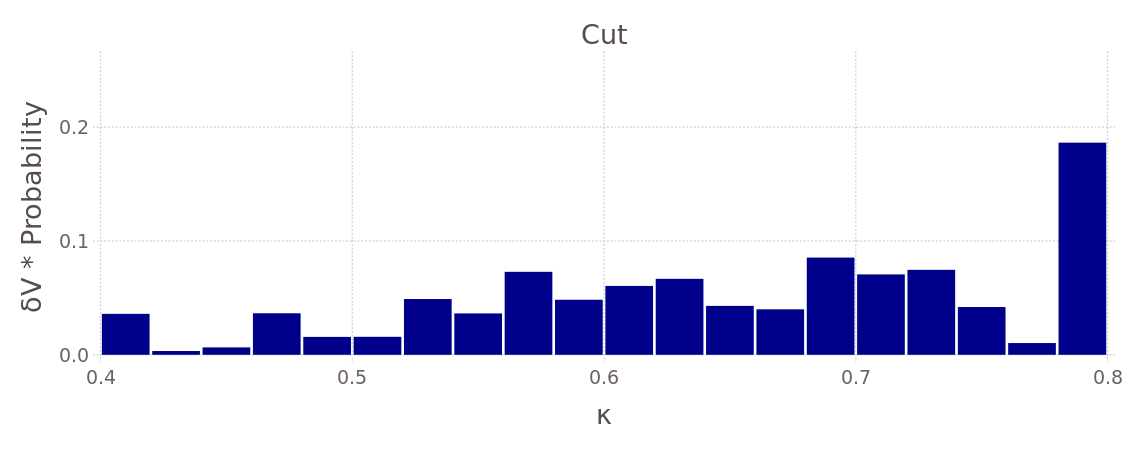

In [15]:
# Uso los bins del anterior
# Histograma ponderado
Whis_κ_cut_1ael, Wbins_κ_cut_1ael = WeightedHist(κ_modes_cut_1ael, bins_κ, abs.(vgv_1ael), true);
df_Whis_κ_cut_1ael = DataFrame(Probability = Whis_κ_cut_1ael, κ = Wbins_κ_cut_1ael);

pdf_Whis_κ_cut_1ael = plot(df_Whis_κ_cut_1ael, x="κ", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad en pnumber

### Modos enteros

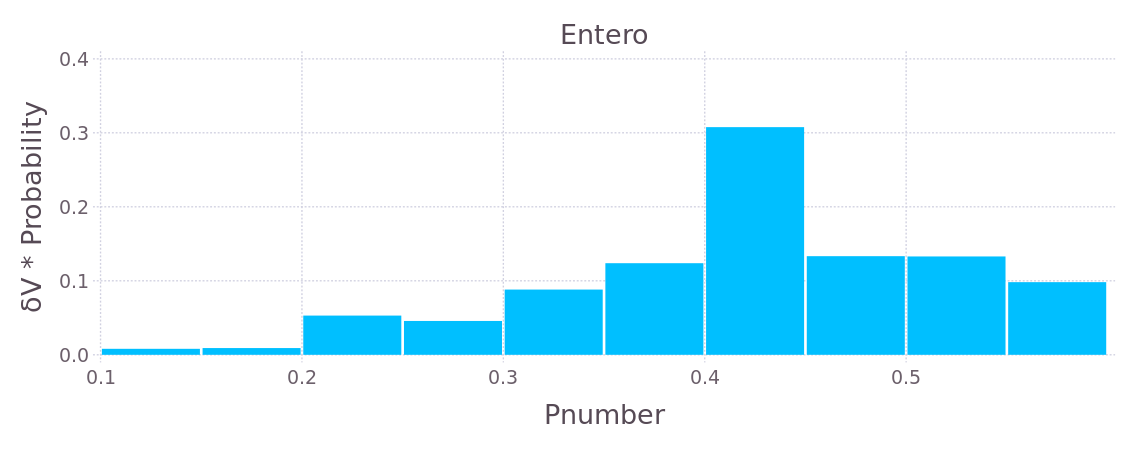

In [16]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_1ael)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_1ael, Wbins_col_1ael = WeightedHist(col_modes_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_1ael = DataFrame(Probability = Whis_col_1ael, Pnumber = Wbins_col_1ael);

pdf_Whis_col_1ael = plot(df_Whis_col_1ael, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    # Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Modos recortados

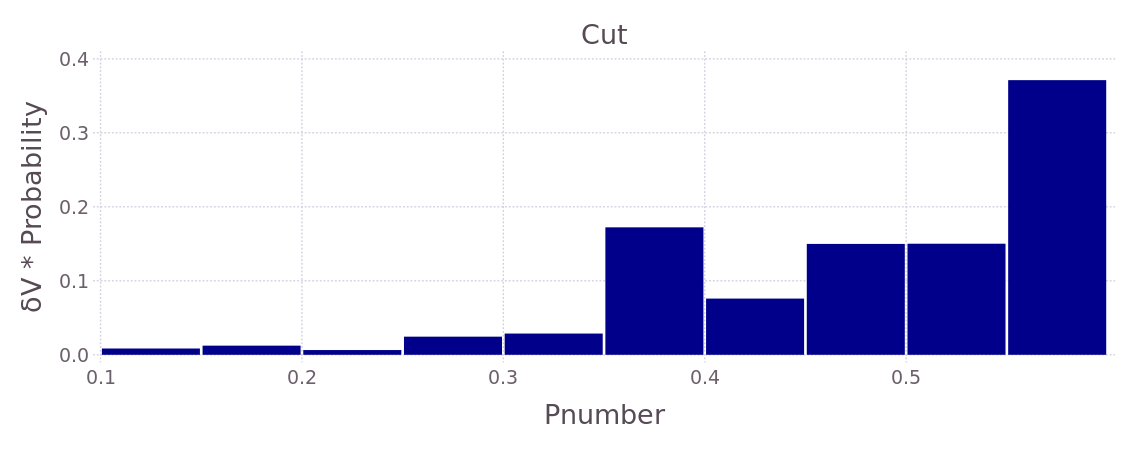

In [17]:
# Uso los bins de arriba
# Histograma ponderado
    Whis_col_cut_1ael, Wbins_col_cut_1ael = WeightedHist(col_modes_cut_1ael, bins_col, abs.(vgv_1ael), true);
df_Whis_col_cut_1ael = DataFrame(Probability = Whis_col_cut_1ael, Pnumber = Wbins_col_cut_1ael);

pdf_Whis_col_cut_1ael = plot(df_Whis_col_cut_1ael, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## AAs de la pared

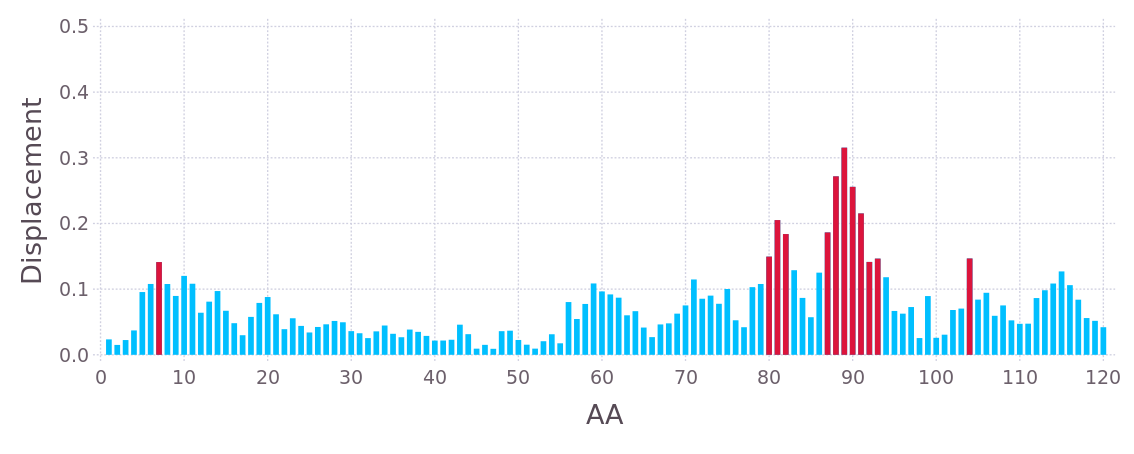

In [18]:
tmp = abs.(xyz_vgv_1ael)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

## Volumen de la trayectoria

In [19]:
trj_vol = readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 2];
df_trj_vol = DataFrame(Volume = trj_vol, Time = collect(1:length(trj_vol)));

bin_vol = collect(400:50:1600)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_1ael, Wbins_vol_1ael = WeightedHist(trj_vol, bin_vol, wgh_vol, true);
df_Whis_vol_1ael = DataFrame(Probability = Whis_vol_1ael, Volume = Wbins_vol_1ael);

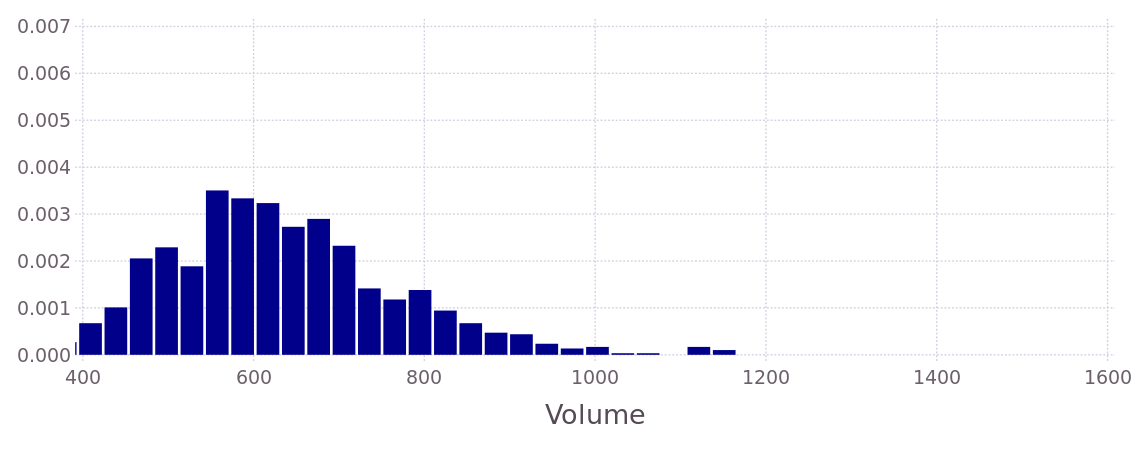

In [20]:
pdf_trj_vol = plot(df_trj_vol, x = "Volume", Geom.histogram(bincount = 30, density = true),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 400, xmax = 1600, ymax = 0.007),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

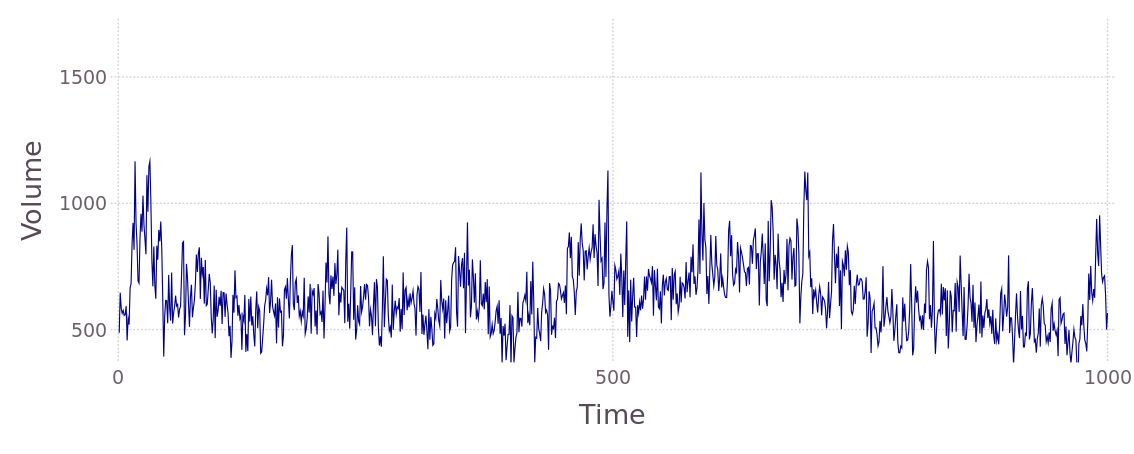

In [21]:
pdf_trj_vol = plot(df_trj_vol, x = "Time", y = "Volume", Geom.line,
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 0, xmax = 1000, ymin = 400, ymax = 1700),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Energía

In [72]:
points = 21
max = floor(points / 2)
min = -max

E_1ael = Array{Float64,1}(points)
i = 0
for d = min:max
    i+=1
    E_1ael[i] = energia_gdte(evals_1ael, vgv_1ael, d * 1e-1)
end

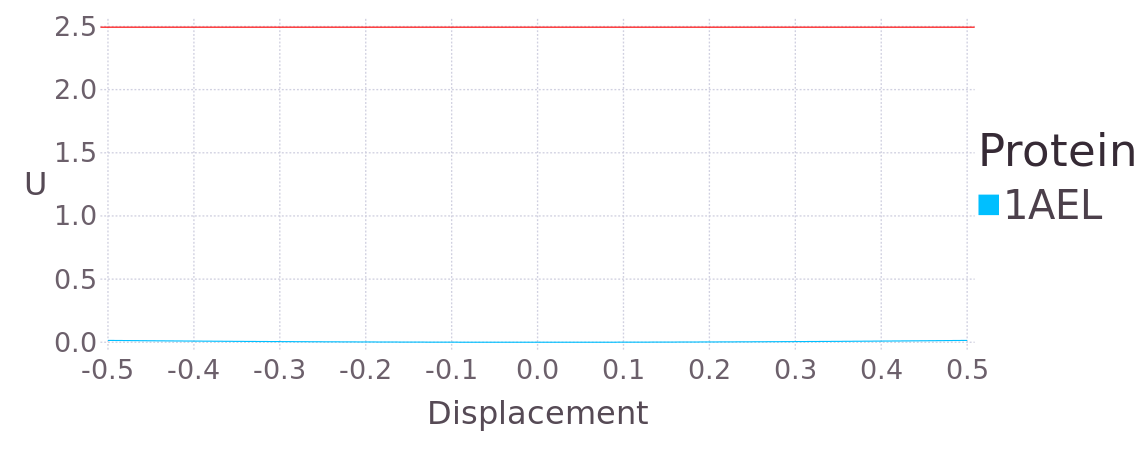

In [73]:
# Compilo en un dataframe.
df_E = DataFrame(U = E_1ael ,
Displacement = repeat(collect(min:1:max) * 5e-2, outer = [1]), 
Protein = fill("1AEL", points))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
yintercept = [RT], Geom.hline(color = "red"),
Guide.xticks(ticks = collect(min:2:max) * 5e-2),

Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
key_label_font_size = 30pt))

In [60]:
RT

2.4943379762449402

In [76]:
function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 300
    const RT_cal = 0.593 # Kcal/mol
    const RT = k * avgdro * T * .001 # KJ/mol
    const RT_ = k * avgdro * T # J/mol
    const cte = 11792.08316093831
    
    const gdte_mod = gdte ./ sum(gdte)
    
    return d^2 * 0.5 * RT_cal * sum(evals.^2 .* gdte.^2) / cte # KJ/mol
end

energia_gdte (generic function with 2 methods)

In [64]:
# Declaro cte de boltzmann, avogadro, y temperatura.
k = 1.38064852e-23
avgdro = 6.0221409e+23
T = 300 
RT_cal = 0.593 # Kcal/mol
RT = k * avgdro * T * .001 # KJ/mol
cte = 11792.08316093831

11792.08316093831

In [98]:
d = .5
(d)^2 * 0.5 * RT_cal * sum((evals_1ael./1e-8 .* mod_gdte).1e-8.^2) # KJ/mol

LoadError: [91msyntax: missing comma or ) in argument list[39m

In [77]:
sum(evals_1ael.^2 .* vgv_1ael.^2)

252.86916841973965

In [82]:
mod_gdte = abs.(vgv_1ael) ./ sum(abs.(vgv_1ael))

354-element Array{Float64,1}:
 0.146841   
 0.0326145  
 0.0185395  
 0.0419221  
 0.0296633  
 0.0116913  
 0.00862656 
 0.00635641 
 0.0015891  
 0.0093076  
 0.0041241  
 0.00643208 
 0.0244798  
 ⋮          
 0.0        
 3.78358e-5 
 0.0        
 0.000529701
 3.78358e-5 
 3.78358e-5 
 3.78358e-5 
 0.000340522
 0.000416194
 0.0        
 0.000113507
 0.000264851

In [88]:
sum(mod_gdte)

0.9999999999999998

## Guardo datos

In [22]:
# VGV cartesiano
car_vgv_1ael = modes_1ael * vgv_1ael
writedlm(joinpath(rtdos, "car_vgv_1ael"), car_vgv_1ael)